### Importing All Libraries

In [19]:
#Importing pandas for data manipulation on a DataFrame
import pandas as pd  
#Importing random to first generate a random data of some features on which data analysis will be done
import random
#Importing datetime and timedelta to filter data based on date
from datetime import datetime, timedelta
#Importing seaborn for statistically visualise data
import seaborn as sns
#Importing matplotlib.plt to create visualisations
import matplotlib.pyplot as plt 
#Importing OneHotEncoder to convert categorical fields to binary format for machine learning tasks
from sklearn.preprocessing import OneHotEncoder
#Importing numpy for doing operations on array
import numpy as np

### Creating Data
About the data:
The data represents the finances of a single individual over the course of one month from the current date which is (20th October 2024).
The dataframe has the following features:
1) account_number: 

        Meaning- Represents the account number associated to a particular individual.
        Data Type- str
        Values it will contain- 'xx4352', 'xx2313', 'xx4354'
2) transaction_type: 

        Meaning- Represents whether the amount was credited to account or debited from account number
        Data Type- str
        Values it will contain- either 'credit' or 'debit'       
3) amount:

        Meaning: The amount which was transacted through a particular transactional channel.
        Data Type- float
        Constraint applied during random generation- Values between 10.00 and 1000.00 (both inclusive) to represent transaction amounts.
4) date:

        Meaning: The date on which the transaction took place.
        Data Type- datetime
        Constraint applied during random generation- Sequentially generated dates within the last 30 days from the current date.
5) balance:

        Meaning: The balance in that particular account after the transaction took place.
        Data Type- float
6) transaction_channel:

        Meaning: The transaction_method of making payment.
        Data Type- str
        Values it will contain- 'net_banking_transfer', 'upi', 'debit_card'
        Note: UPI (Unified Payments Interface) is a real-time payment system in India that enables users to instantly transfer funds between bank accounts through a mobile application.

In [14]:
'''
Function to generate data 
Parameter: records (representing number of data , in this case 100)
Output: dataframe representing the transaction logs
'''
def generate_data(records):
    transaction_types = ['credit', 'debit']
    transaction_channels = ['net_banking_transfer', 'upi', 'debit_card']
    account_numbers = ['xx4352', 'xx2313', 'xx4354']
    
    # Initialize account balances
    account_balances = {'xx4352': 3000.00, 'xx2313': 2500.00, 'xx4354': 4000.00}
    
    # Generate sequential dates for transactions
    start_date = datetime.now() - timedelta(days=30)
    date_list = [start_date + timedelta(days=i) for i in range(records)]
    
    # Shuffle dates to randomize transaction order
    random.shuffle(date_list)
    
    data = []
    
    for date in sorted(date_list):  # Sorted to ensure dates are in increasing order
        # Randomly select an account number and a transaction channel
        account_number = random.choice(account_numbers)  
        transaction_channel = random.choice(transaction_channels)
        
        # If transaction channel is 'debit_card', assign the transaction_type as debit, 
        # as most debit card transaction in real worldare of type debit.
        if transaction_channel == 'debit_card':
            transaction_type = 'debit'
        # Assign a random transaction type for other channels i.e. upi and net_banking_transfer
        else:
            transaction_type = random.choice(transaction_types)  
        # Generate random amounts between the constraints
        amount = round(random.uniform(10, 1000), 2) 
        
        # Update balance based on transaction type
        if transaction_type == 'credit':
            account_balances[account_number] += amount  # In case of credit the amount is added to the previous balance in that particular account.
        else:  #debit
            # In case the balance is above 0 after debiting the amount, the amount is subtracted from the previous balance in that particular account.
            if account_balances[account_number] >= amount:  
                account_balances[account_number] -= amount  
            else: # If the balance goes below 0 after debiting the amount, the amount is set to 0.
                amount = 0  
        
        # Append data with the current balance of the specific account
        data.append([account_number, transaction_type, amount, date.strftime("%Y-%m-%d"), round(account_balances[account_number], 2), transaction_channel])
    
    return pd.DataFrame(data, columns=['account_number','transaction_type', 'amount', 'date', 'balance', 'transaction_channel'])

In [15]:
# Generate data and save to CSV
transaction_logs_dataframe = generate_data(100)
transaction_logs_dataframe.to_csv('transaction_logs.csv', index=False)

### Ingesting data from CSV file

In [28]:
transaction_logs_df = pd.read_csv('transaction_logs.csv')
transaction_logs_df.sample(5)

,account_number,transaction_type,amount,date,balance,transaction_channel
33,xx4352,credit,951.97,2024-10-28,8039.74,net_banking_transfer
63,xx4352,debit,82.39,2024-11-27,5381.95,upi
79,xx2313,debit,435.67,2024-12-13,2438.91,debit_card
39,xx4354,debit,731.45,2024-11-03,603.78,upi
54,xx4352,debit,939.96,2024-11-18,5559.93,debit_card


### Manage different data types

In [29]:
# Checking data types
print("Data types of each column:")
print(transaction_logs_df.dtypes)
print("Initial data type of date column:", type(transaction_logs_df.at[0,'date']))
# converting date from string to datetime format
transaction_logs_df['date']= pd.to_datetime(transaction_logs_df['date'])
print("Final data type of date column:", type(transaction_logs_df.at[0,'date']))

Data types of each column:
account_number          object
transaction_type        object
amount                 float64
date                    object
balance                float64
transaction_channel     object
dtype: object
Initial data type of date column: <class 'str'>
Final data type of date column: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [22]:
print("Initial data type of date column:", type(transaction_logs_df.at[0,'date']))
# converting date from string to datetime format
transaction_logs_df['date']= pd.to_datetime(transaction_logs_df['date'])
print("Final data type of date column:", type(transaction_logs_df.at[0,'date']))

Initial data type of date column: <class 'str'>
Final data type of date column: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


### Creating features based on this data through a function
Features:
1) Average balance maintained in each account in the past 7, 15, and 30 days.
2) Maximum balance maintain in each account in the past 7, 15, and 30 days.
3) Total Average balance combining all account in the past 7,15, and 30 days.
4) Account with maximum Average balance in the past 7,15, and 30 days.
5) Count of credits and debits per account.
6) Transaction channel used most frequently per account number.
7) Amount credited or debited through each transaction channel (all accounts included).
8) Date at which maximum amount was credit and date at which minimum amount was debited (all accounts included).
9) Percentage increase/decrease in balance on current date(latest date in the data) with respect to initial balance.


In [23]:
'''
Function to generate function based on transaction logs
Function parameters: df- DataFrame containing the data.
Output: returns a dataframe of transaction features.
'''
def get_transaction_features(df):
    transaction_feature_dict = dict()
    # current date represents the most recent date of the data
    current_date=df['date'].max()
    # Grouped the DataFrame by account_number to avoid repetitive filtering
    grouped=df.groupby('account_number')
    # Process each account in the group
    avg_balances={}
    for account,account_data in grouped:
        account_data=account_data.sort_values(by='date').reset_index(drop=True)
        initial_balance=account_data.at[0,'balance']
        current_balance=account_data.iloc[-1]['balance']
        count_of_credit_transactions=len(account_data[account_data['transaction_type']=='credit'])
        count_of_debit_transactions=len(account_data[account_data['transaction_type']=='debit'])
        transaction_channel_frequently_used = account_data['transaction_channel'].value_counts().idxmax()
        transaction_feature_dict[f'count_of_credit_transactions_acc:{account}']=count_of_credit_transactions
        transaction_feature_dict[f'count_of_debit_transactions_acc:{account}']=count_of_debit_transactions
        transaction_feature_dict[f'transaction_channel_frequently_used_acc:{account}']=transaction_channel_frequently_used
        # Loop over 7, 15, 30 days periods to calculate balances
        for suffix in [7,15,30]:
            avg_balance=0
            max_balance=None  # Initialize max_balance to avoid carry over from previous iterations
            # Creating a smaller dataset containing entries from the most recent data till the past n(suffix) days.
            recent_period = account_data[account_data['date'] >= current_date - timedelta(days=suffix)]
            # If recent period is not empty, only then find avg and max balance
            if not recent_period.empty:
                avg_balance=recent_period['balance'].mean()
                max_balance=recent_period['balance'].max()
            transaction_feature_dict[f'avg_balance_acc:{account}_last_{suffix}_days']=avg_balance
            transaction_feature_dict[f'max_balance_acc:{account}_last_{suffix}_days']=max_balance
            # Store the average balance for later usage to find account with max average over n(suffix) days
            avg_balances[(account,suffix)]=avg_balance
        # Calculate percentage increase/decrease in balance
        if current_balance>initial_balance:
            transaction_feature_dict[f'percentage_increase_in_balance_acc:{account}']=((
                current_balance-initial_balance)/initial_balance)*100
        else:
            transaction_feature_dict[f'percentage_decrease_in_balance_acc:{account}']=((
                initial_balance-current_balance)/initial_balance)*100
    # Total average balance across all accounts for 7, 15, 30 days
    for suffix in [7,15,30]:
        recent_period=df[df['date']>=current_date-timedelta(days=suffix)]
        if not recent_period.empty:
            total_avg_balance=recent_period['balance'].mean()
            transaction_feature_dict[f'total_avg_balance_last_{suffix}_days']=total_avg_balance
    # Find the account with the maximum average balance over 7,15,30 days
    for suffix in [7,15,30]:
        transaction_feature_dict[f'acc_with_max_avg_balance_past_{suffix}_days']=max(
            grouped.groups.keys(),key=lambda acc: avg_balances.get((acc, suffix),0))
    # Calculate total amount credited or debited through each transaction channel
    for channel in df['transaction_channel'].unique():
        transaction_feature_dict[f'amount_credited_transaction_channel:{channel}']=df[
            df['transaction_channel']==channel]['amount'].sum()
    # Date of max credit and min debit transactions
    # Created a smaller dataset containing only transaction which have transaction_type as credit or 
    # debits respectively.
    credit_transactions=df[df['transaction_type']=='credit']
    debit_transactions=df[df['transaction_type']=='debit']
    # A check to make sure credit or debit transaction is not empty or doesn't contain all null values.
    if not credit_transactions.empty and not credit_transactions['amount'].isnull().all():
        date_max_credit_transaction=credit_transactions.loc[credit_transactions['amount'].idxmax(),'date']
    else:
        date_max_credit_transaction=None
    if not debit_transactions.empty and not debit_transactions['amount'].isnull().all():
        date_min_debit_transaction=debit_transactions.loc[debit_transactions['amount'].idxmin(),'date']
    else:
        date_min_debit_transaction=None
    transaction_feature_dict['date_of_maximum_credit_transaction']=date_max_credit_transaction
    transaction_feature_dict['date_of_minimum_debit_transaction']=date_min_debit_transaction
    transaction_features_df=pd.DataFrame(list(transaction_feature_dict.items()),columns=['feature_labels','values'])
    return transaction_features_df



In [27]:
transaction_features_df=get_transaction_features(transaction_logs_df)
transaction_features_df

,feature_labels,values
0,count_of_credit_transactions_acc:xx2313,16
1,count_of_debit_transactions_acc:xx2313,18
2,transaction_channel_frequently_used_acc:xx2313,upi
3,avg_balance_acc:xx2313_last_7_days,2748.23
4,max_balance_acc:xx2313_last_7_days,2950.04
5,avg_balance_acc:xx2313_last_15_days,2870.8
6,max_balance_acc:xx2313_last_15_days,3115.94
7,avg_balance_acc:xx2313_last_30_days,2792.315
8,max_balance_acc:xx2313_last_30_days,3324.22
9,percentage_increase_in_balance_acc:xx2313,34.287854


### Performing Data Wrangling 

In [25]:
# Even though the data does not have any missing values, still to demonstrate handling these cases 
# we can fill the na values with median value of that column
transaction_logs_df['amount'] = transaction_logs_df['amount'].fillna(transaction_logs_df['amount'].median())

# Dropping any duplicate rows to maintain originality of data, and avoid repeated entries, which may skew the analysis
transaction_logs_df = transaction_logs_df.drop_duplicates()

# One hot encoding transaction channel, it could be useful when building machine learning model.
#  One hot encoding will convert categorical columns to binary format.
encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(transaction_logs_df[['transaction_channel']])

# Storing the one hot encodings in encoded_df and then concatanating it with original dataframe.
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['transaction_channel']))
transaction_logs_df = pd.concat([transaction_logs_df, encoded_df], axis=1)

# Counting outlier values in balance by detecting values less than 1.5 times of interquartile range from 25th percentile 
# and more than 1.5 times of interquartile range from 75th percentile
first_quartile = np.percentile(transaction_logs_df['balance'], 25)
third_quartile = np.percentile(transaction_logs_df['balance'], 75)
interquartile_range= third_quartile-first_quartile
lower_bound = first_quartile - 1.5 * interquartile_range
upper_bound = third_quartile + 1.5 * interquartile_range
outliers = transaction_logs_df[(transaction_logs_df['balance'] < lower_bound) 
                               | (transaction_logs_df['balance'] > upper_bound)]
print("Count of outliers in balance values:",len(outliers))


Count of outliers in balance values: 0


### Data Visualisation

Using seaborn to visualise average and maximum balances in different accounts over the past 7,15 and 30 days.\
Using matplotlib.pyplot to visualise total average balance over the past 7,15 and 30 days.

In [30]:
"""
Function to visualize average, maximum, and total balances for different accounts over the past 7, 15, and 30 days.
Function parameters: transaction_features_dataframe which containing transaction features over different periods.
Output: returns graphs of above mentioned features over different period.
"""
def visualize_account_balances(features_dataframe):
    accounts = ['xx2313','xx4352','xx4354']
    days = [7,15,30]
    # Initialize dictionaries to store average and max balances for each account
    avg_balances={acc:[] for acc in accounts}
    max_balances={acc:[] for acc in accounts}
    # extracting average and max balances for past 7, 15, and 30 days
    for acc in accounts:
        for day in days:
            avg_balance_col=f'avg_balance_acc:{acc}_last_{day}_days'
            max_balance_col=f'max_balance_acc:{acc}_last_{day}_days'
            avg_balance=features_dataframe[features_dataframe['feature_labels']==avg_balance_col]['values'].values[0]
            max_balance=features_dataframe[features_dataframe['feature_labels']==max_balance_col]['values'].values[0]
            avg_balances[acc].append(avg_balance)
            max_balances[acc].append(max_balance)
    # Prepare data for visualising average and maximum balance over different periods using seaborn
    balance_data=[]
    for acc in accounts:
        for i,day in enumerate(days):
            balance_data.append({
                'Account':acc,
                'Days':day,
                'Average Balance':avg_balances[acc][i],
                'Maximum Balance':max_balances[acc][i]})
    # added data to a dataframe from which visualisation will be made
    balance_df = pd.DataFrame(balance_data)
    # Plot average and maximum balances for past 7, 15, and 30 days using Seaborn
    plt.figure(figsize=(12, 6))
    # Average balances are represented using solid lines
    for acc in accounts:
        sns.lineplot(data=balance_df[balance_df['Account']==acc],x='Days',y='Average Balance',marker='o',linestyle='-',
                     label=f'Account {acc}-Average Balance')
    # Maximum balances are represented using dotted lines
    for acc in accounts:
        sns.lineplot(data=balance_df[balance_df['Account']==acc],x='Days',y='Maximum Balance',marker='x',linestyle='--',
                     label=f'Account {acc}-Maximum Balance')
    # Writing the title,x-axis,and y axis of the plot
    plt.title('Average and Maximum Balances Over Last 7, 15, and 30 Days')
    plt.xlabel('Days')
    plt.ylabel('Balance')
    plt.grid(True)
    plt.legend(title='Account Balances',loc='upper right',bbox_to_anchor=(1, 1))
    plt.show()
    # Fetch total average balances for last 7, 15, and 30 days
    total_avg_balances=[]
    for day in days:
        total_avg_col=f'total_avg_balance_last_{day}_days'
        total_avg_balance=features_dataframe[features_dataframe['feature_labels']==total_avg_col]['values'].values[0]
        total_avg_balances.append(total_avg_balance)
    # Plot total average balances for past 7, 15, and 30 days using Matplotlib
    plt.figure(figsize=(10, 6))
    plt.plot(days, total_avg_balances,marker='o',label='Total Average Balance',color='black')
    plt.title('Total Average Balance Over Last 7, 15, and 30 Days')
    plt.xlabel('Days')
    plt.ylabel('Total Average Balance')
    plt.grid(True)
    plt.legend()
    plt.show()

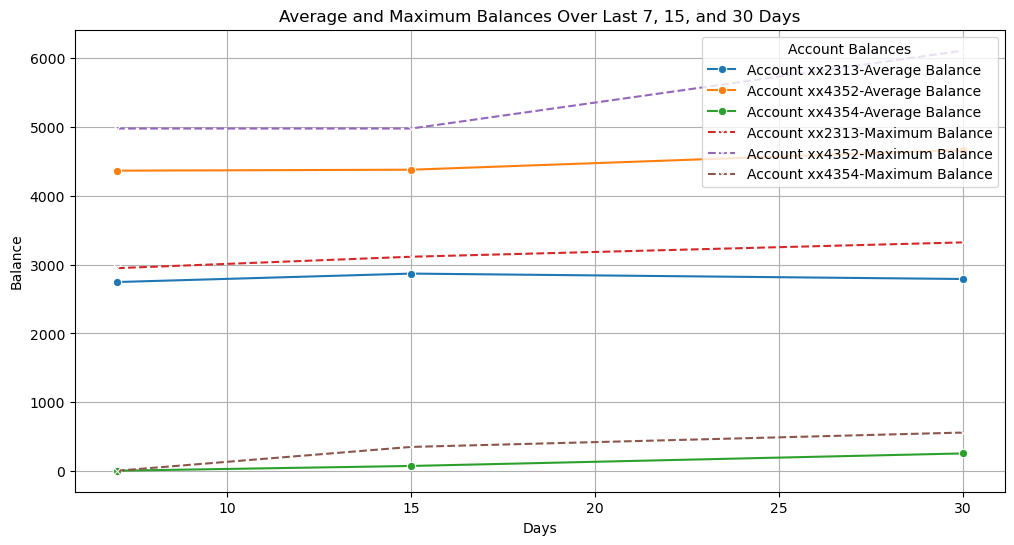

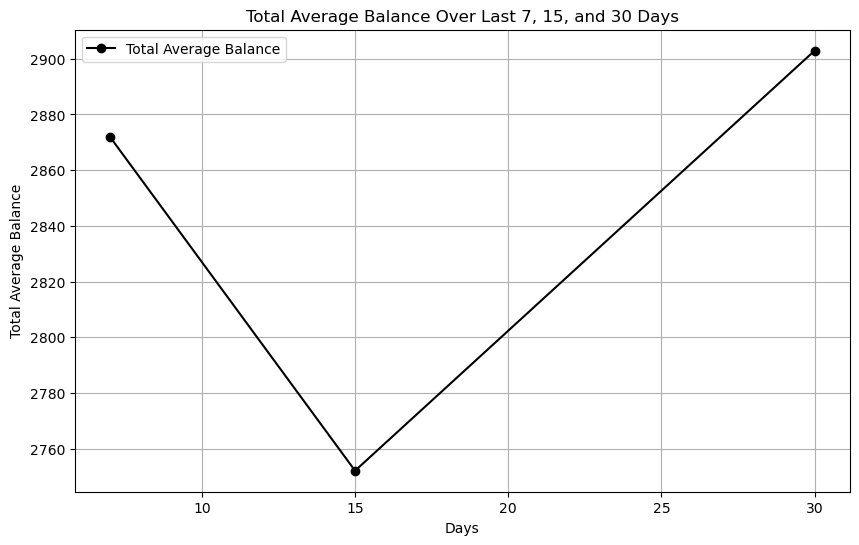

In [32]:
visualize_account_balances(transaction_features_df)